In [1]:
# ==== CELL 0A: Install deps (pin) ====
!pip -q install --no-cache-dir faiss-cpu==1.12.0
!pip -q install --no-cache-dir open-clip-torch==2.24.0
!pip -q install --no-cache-dir ultralytics==8.3.225
# Giữ phiên bản ổn định để tránh lỗi import dây chuyền
!pip -q install --no-cache-dir "scipy==1.11.4" "scikit-learn==1.3.2"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 236.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 209.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 217.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 221.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 252.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 229.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 234.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 254.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 251.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 249.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━

In [2]:
# ==== CELL 0B: Imports & versions ====
from pathlib import Path
import json, io, time, requests
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import torch, faiss, open_clip
from ultralytics import YOLO

print("Device:", "cuda" if torch.cuda.is_available() else "cpu")
print("NumPy:", np.__version__, "| FAISS:", faiss.__version__)
print("open_clip imported | ultralytics:", YOLO.__module__.split('.')[0])


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cpu
NumPy: 1.26.4 | FAISS: 1.12.0
open_clip imported | ultralytics: ultralytics


In [4]:
# ==== CELL 1: Config ====
# Dataset retrieval chỉ gồm 2 file này
RETR_ROOT  = Path("/kaggle/input/dataforretrievalembedded")   # <== ĐỔI TÊN Ở ĐÂY
FAISS_PATH = RETR_ROOT / "faiss_IndexFlatIP.faiss"
IDMAP_PATH = RETR_ROOT / "id_map.json"

# OpenCLIP phải TRÙNG với preprocess
CLIP_MODEL    = "ViT-B-16"
CLIP_PRETRAIN = "dfn2b"   # hoặc "webli" nếu bạn đã preprocess bằng webli

# YOLO detect
YOLO_WEIGHTS = "yolo11n.pt"   # auto-download
YOLO_CONF    = 0.25
YOLO_IOU     = 0.45
YOLO_CLASSES = [15, 16]       # COCO: 15=cat, 16=dog

# Retrieval
TOPK = 5

# Output dirs
WORK      = Path("/kaggle/working")
OUT_DIR   = WORK / "retrieval_out"
CROPS_DIR = OUT_DIR / "query_crops"
OUT_DIR.mkdir(parents=True, exist_ok=True)
CROPS_DIR.mkdir(parents=True, exist_ok=True)

# === NHẬP ẢNH TEST Ở ĐÂY ===
# Bạn có thể để 1 URL ảnh Google bất kỳ (ảnh con CHÓ để test)
QUERY_IMAGE = "https://lapaw.vn/wp-content/uploads/2024/09/Thong-tin-Cho-Husky.jpg"

# Kiểm tra input files
assert FAISS_PATH.exists(), f"Missing FAISS index: {FAISS_PATH}"
assert IDMAP_PATH.exists(),  f"Missing id_map.json: {IDMAP_PATH}"
print("OK: Found", FAISS_PATH.name, "and", IDMAP_PATH.name)


OK: Found faiss_IndexFlatIP.faiss and id_map.json


In [5]:
# ==== CELL 2: Load FAISS, id_map, OpenCLIP ====
index = faiss.read_index(str(FAISS_PATH))
faiss_dim = index.d
print("FAISS index loaded. dim:", faiss_dim, "| ntotal:", index.ntotal)

# id_map có thể là list hoặc dict
with open(IDMAP_PATH, "r", encoding="utf-8") as f:
    id_map_raw = json.load(f)

def id_lookup(i: int):
    if isinstance(id_map_raw, dict):
        key = str(i)
        return id_map_raw[key] if key in id_map_raw else {}
    else:
        # list
        return id_map_raw[i] if 0 <= i < len(id_map_raw) else {}

device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(
    CLIP_MODEL, pretrained=CLIP_PRETRAIN, device=device
)
model.eval()

# Sanity check chiều vector
with torch.no_grad():
    dummy = preprocess(Image.new("RGB",(224,224),(0,0,0))).unsqueeze(0).to(device)
    f = model.encode_image(dummy)
    f = torch.nn.functional.normalize(f, dim=-1)
clip_dim = int(f.shape[-1])
assert clip_dim == faiss_dim, f"Dim mismatch: CLIP {clip_dim} vs FAISS {faiss_dim}"
print("OpenCLIP ready. dim matched.")


FAISS index loaded. dim: 512 | ntotal: 22126


open_clip_pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

OpenCLIP ready. dim matched.


In [6]:
# ==== CELL 3: YOLO & helpers ====
yolo = YOLO(YOLO_WEIGHTS)  # auto-download nếu chưa có
print("YOLO ready:", YOLO_WEIGHTS)

def fetch_image(src: str) -> Path:
    """Tải URL hoặc dùng path local, trả về path local."""
    p = Path(src)
    if src.startswith("http://") or src.startswith("https://"):
        out = WORK / f"query_{int(time.time()*1000)}.jpg"
        r = requests.get(src, timeout=20)
        r.raise_for_status()
        Image.open(io.BytesIO(r.content)).convert("RGB").save(out, quality=95)
        return out
    else:
        assert p.exists(), f"Local path not found: {src}"
        return p

def yolo_best_dogcat_box(img_path: Path):
    """Trả về bbox (x1,y1,x2,y2) của detection dog/cat có conf cao nhất; nếu không có -> (None, None)."""
    res = yolo.predict(source=str(img_path), conf=YOLO_CONF, iou=YOLO_IOU,
                       classes=YOLO_CLASSES, verbose=False)
    r = res[0]
    if r.boxes is None or r.boxes.shape[0] == 0:
        return None, None
    confs = r.boxes.conf.cpu().numpy()
    i_best = int(np.argmax(confs))
    xyxy  = r.boxes.xyxy.cpu().numpy().astype(int)[i_best]
    return tuple(int(v) for v in xyxy[:4]), float(confs[i_best])

def crop_with_pad(img_path: Path, box, pad=2) -> Image.Image:
    im = Image.open(img_path).convert("RGB")
    if box is None:
        return im
    x1,y1,x2,y2 = box
    x1 = max(0, x1 - pad); y1 = max(0, y1 - pad)
    x2 = min(im.width,  x2 + pad); y2 = min(im.height, y2 + pad)
    if x2 <= x1 or y2 <= y1:
        return im
    return im.crop((x1,y1,x2,y2))

def embed_pil(img: Image.Image) -> np.ndarray:
    with torch.no_grad():
        t = preprocess(img).unsqueeze(0).to(device)
        f = model.encode_image(t)
        f = torch.nn.functional.normalize(f, dim=-1)
    return f.cpu().numpy().astype("float32")  # (1, D)

def faiss_search(vec: np.ndarray, topk=5):
    sims, idxs = index.search(vec, topk)
    return sims[0].tolist(), [int(i) for i in idxs[0]]

def weighted_vote_breed(sims, ids):
    """Gộp theo breed bằng tổng similarity (cosine) và trả về (best_breed, table)."""
    agg = {}
    rows = []
    for rank, (sid, sc) in enumerate(zip(ids, sims), start=1):
        meta = id_lookup(sid)
        breed = meta.get("breed", "UNKNOWN")
        agg[breed] = agg.get(breed, 0.0) + float(sc)
        rows.append({
            "rank": rank,
            "index": sid,
            "breed": breed,
            "score": float(sc),
            "ref_crop_path": meta.get("crop_path",""),
            "ref_src_path":  meta.get("src_path","")
        })
    # breed score cao nhất
    best_breed = max(agg.items(), key=lambda kv: kv[1])[0] if agg else "UNKNOWN"
    vote_table = pd.DataFrame(rows)
    vote_table["breed_vote_sum"] = vote_table["breed"].map(lambda b: agg.get(b, 0.0))
    return best_breed, vote_table.sort_values(["breed_vote_sum","score"], ascending=False)


YOLO ready: yolo11n.pt


=== QUERY ===
Input: https://lapaw.vn/wp-content/uploads/2024/09/Thong-tin-Cho-Husky.jpg


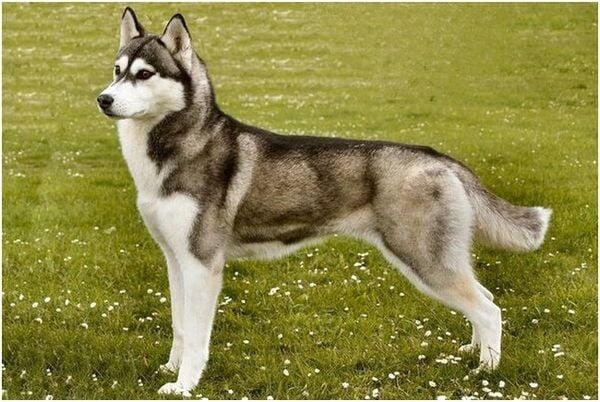

[YOLO] box=(93, 6, 553, 394) | conf=0.916


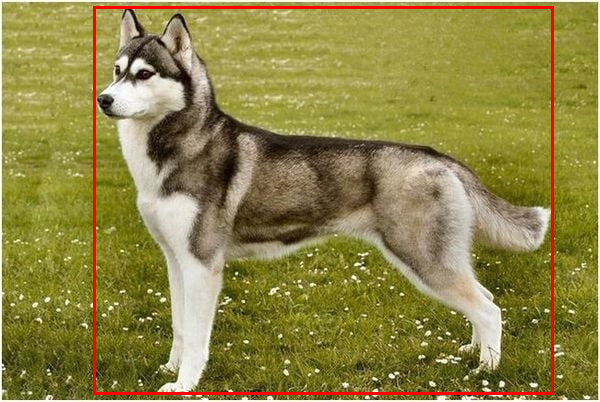

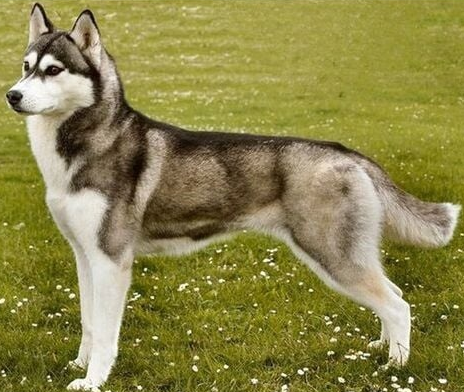


=== KẾT LUẬN ===
→ Dự đoán GIỐNG: n02110185-Siberian_husky

Top-5 kết quả gần nhất (cosine sim):


,rank,index,breed,score,ref_crop_path,ref_src_path,breed_vote_sum
0,2,18126,n02110185-Siberian_husky,0.907820,/kaggle/working/crops_gt/n02110185-Siberian_hu...,/kaggle/input/pawverse-pipeline-data/stanford-...,2.696552
1,4,18042,n02110185-Siberian_husky,0.899469,/kaggle/working/crops_gt/n02110185-Siberian_hu...,/kaggle/input/pawverse-pipeline-data/stanford-...,2.696552
2,5,18121,n02110185-Siberian_husky,0.889263,/kaggle/working/crops_gt/n02110185-Siberian_hu...,/kaggle/input/pawverse-pipeline-data/stanford-...,2.696552
3,1,17661,n02109961-Eskimo_dog,0.913814,/kaggle/working/crops_gt/n02109961-Eskimo_dog/...,/kaggle/input/pawverse-pipeline-data/stanford-...,1.820172
4,3,17670,n02109961-Eskimo_dog,0.906358,/kaggle/working/crops_gt/n02109961-Eskimo_dog/...,/kaggle/input/pawverse-pipeline-data/stanford-...,1.820172


In [7]:
# ==== CELL 4: Run single query & display ====
from IPython.display import display

def run_query_show(src: str, topk=TOPK):
    print("=== QUERY ===")
    print("Input:", src)
    p = fetch_image(src)

    # Hiển thị ảnh gốc
    im = Image.open(p).convert("RGB")
    display(im)

    # YOLO detect
    box, conf = yolo_best_dogcat_box(p)
    if box is None:
        print("\n[YOLO] Không phát hiện chó/mèo trong ảnh. Vui lòng thử ảnh khác (góc rõ hơn, ít vật thể che khuất).")
        return

    # Vẽ box lên ảnh và crop
    x1,y1,x2,y2 = box
    im_box = im.copy()
    dr = ImageDraw.Draw(im_box)
    dr.rectangle([x1,y1,x2,y2], outline=(255,0,0), width=3)
    print(f"[YOLO] box={box} | conf={conf:.3f}")
    display(im_box)

    crop = crop_with_pad(p, box, pad=2)
    display(crop)

    # Embed + search
    qvec = embed_pil(crop)
    sims, ids = faiss_search(qvec, topk=topk)

    # Vote theo breed
    best_breed, vote_df = weighted_vote_breed(sims, ids)

    print("\n=== KẾT LUẬN ===")
    print(f"→ Dự đoán GIỐNG: {best_breed}")
    print("\nTop-{} kết quả gần nhất (cosine sim):".format(topk))
    display(vote_df.reset_index(drop=True))

# ---- chạy 1 ảnh test (đổi QUERY_IMAGE ở Cell 1) ----
run_query_show(QUERY_IMAGE, topk=TOPK)
